In [1]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


# Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''


class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''

    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min

    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction

    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert (responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D))  # number of features to consider for each split decision

        # initialize the root node
        self.root = Node()
        self.root.features = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None:  # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)

    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature
                         indices to be considered for the present split

        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None

        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None:  # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        ...  # your code here

        node.left=left
        node.right=right
        node.split_index=j_min
        node.threshold=t_min

        #raise NotImplementedError("make_split_node(): remove this exception after adding your code above.")

        # return the children (to be placed on the stack)
        return left, right

    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        ...  # your code here
        active_indices = np.random.choice(D, D_try, replace=False)
        return active_indices
        #raise NotImplementedError("select_active_indices(): remove this exception after adding your code above.")

    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        ...  # your code here
        sorted_feature = np.sort(node.features[:,j])
        thresholds = (sorted_feature[1:] + sorted_feature[:-1]) / 2.0

        return thresholds
        #raise NotImplementedError("find_thresholds(): remove this exception after adding your code above.")

    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t

            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()
        left.features = node.features[node.features[:, j] <= t]
        left.responses = node.responses[node.features[:, j] <= t]

        right.features = node.features[node.features[:, j] > t]
        right.responses = node.responses[node.features[:, j] > t]
        # your code here
        #raise NotImplementedError("make_children(): remove this exception after adding your code above.")

        return left, right

    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`

            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")

    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').

            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)

    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        ...  # your code here
        feature_j=node.features[:,j]
        left=feature_j[feature_j<t]
        right=feature_j[feature_j>=t]
        if (len(left) < self.n_min) | (len(right) < self.n_min):
            return float('inf')
        loss = np.var(left) * len(left) + np.var(right) * len(right)
        return loss
        #raise NotImplementedError("compute_loss_for_split(): remove this exception after adding your code above.")

    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        # your code here
        node.prediction = np.mean(node.responses)
        #raise NotImplementedError("make_leaf_node(): remove this exception after adding your code above.")

# Classification Tree

In [4]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''

    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes

    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        left_responses = node.responses[node.features[:, j] <= t]
        right_responses = node.responses[node.features[:, j] > t]
        #feature_j = node.features[:, j]
        #left = feature_j[feature_j < t]
        #right = feature_j[feature_j >= t]
        #left_response = node.responses[left]
        #right_response = node.responses[right]
        if (len(left_responses) < self.n_min) or (len(right_responses) < self.n_min):
            return float('inf')

        left_count = np.bincount(left_responses)
        left_prob = left_count / len(left_responses)
        left_impurity = 1 - np.sum(left_prob ** 2)

        right_count = np.bincount(right_responses)
        right_prob = right_count / len(right_responses)
        right_impurity = 1 - np.sum(right_prob ** 2)

        total = len(left_responses) + len(right_responses)
        loss = (len(left_responses) / total) * left_impurity + (len(right_responses) / total) * right_impurity

        return loss
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        node.prediction=np.argmax(np.bincount(node.responses))
        # your code here
        #raise NotImplementedError("make_leaf_node(): remove this exception after adding your code above.")

# Evaluation of Regression and Classification Tree

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [6]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
# your code here
def regression_tree(features, responses, n_folds=5, n_min=10):
    fold_size = features.shape[0] // n_folds
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)

    total_acc = 0.0

    for i in range(n_folds):
        fold_start = i * fold_size
        fold_end = (i + 1) * fold_size

        validation_indices = indices[fold_start:fold_end]
        train_indices = np.concatenate((indices[:fold_start], indices[fold_end:]))

        train_features = features[train_indices]
        train_responses = responses[train_indices]
        test_features = features[validation_indices]
        test_responses = responses[validation_indices]

        tree = RegressionTree(n_min)
        tree.train(train_features, train_responses)

        predictions = np.array([tree.predict(x) for x in test_features])
        accuracy = np.mean((predictions - test_responses) ** 2)

        total_acc += accuracy

    average_accuracy = total_acc / n_folds
    return average_accuracy
accuracy_regressiontree = regression_tree(features, responses)
print("Regression Tree:", accuracy_regressiontree)

Regression Tree: 0.6749277873883317


In [7]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results
# your code here
def classification_tree(features, labels, classes, n_folds=5, n_min=10):
    fold_size = features.shape[0] // n_folds
    indices = np.arange(features.shape[0])
    np.random.shuffle(indices)

    total_accuracy = 0.0

    for i in range(n_folds):
        fold_start = i * fold_size
        fold_end = (i + 1) * fold_size

        validation_indices = indices[fold_start:fold_end]
        train_indices = np.concatenate((indices[:fold_start], indices[fold_end:]))

        train_features = features[train_indices]
        train_labels = labels[train_indices]
        test_features = features[validation_indices]
        test_labels = labels[validation_indices]

        tree = ClassificationTree(classes, n_min)
        tree.train(train_features, train_labels)
        predictions = np.array([tree.predict(x) for x in test_features])
        accuracy = np.mean(predictions == test_labels)

        total_accuracy += accuracy

    average_accuracy = total_accuracy / n_folds
    return average_accuracy


accuracy_classficationtree = classification_tree(features,labels, np.unique(labels))
print("Classification Tree:", accuracy_classficationtree)

Classification Tree: 0.8527777777777779


# Regression and Classification Forest

In [8]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    # your code here
    N=len(features)
    indices=np.random.choice(N, size=N, replace=True)
    bootstrap_features = features[indices]
    bootstrap_responses = responses[indices]
    return bootstrap_features, bootstrap_responses

    #raise NotImplementedError("bootstrap_sampling(): remove this exception after adding your code above.")


In [9]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]

    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        # your code here
        predictions = [tree.predict(x) for tree in self.trees]
        return np.mean(predictions)
        #raise NotImplementedError("predict(): remove this exception after adding your code above.")



In [10]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes

    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        # your code here
        predictions = [tree.predict(x) for tree in self.trees]
        return np.argmax(np.bincount(predictions))
        #raise NotImplementedError("predict(): remove this exception after adding your code above.")



# Evaluation of Regression and Decision Forest

In [11]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
# your code here
def regression_forest(features,responses,n_folds=5,n_trees=10):
    accuracy_scores = [ ]

    kfold = KFold(n_folds)
    for train_index, test_index in kfold.split(features):
        # Split the data into training and testing sets
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = responses[train_index], responses[test_index]

        forest = RegressionForest(n_trees=n_trees)
        forest.train(X_train, y_train)

        y_pred = [forest.predict(x) for x in X_test]

        accuracy = np.mean(np.sign(y_pred) == y_test)
        accuracy_scores.append(accuracy)
        #accuracy_scores+=accuracy

    average_accuracy = np.mean(accuracy_scores)
    return average_accuracy

accuracy_regressionforest=regression_forest(features,responses)
print('Regresion Forest:',accuracy_regressionforest)


Regresion Forest: 0.862290715372907


In [12]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
# your code here
def classification_forest(features,labels,n_folds=5,n_trees=10):
    accuracy_scores = [ ]

    kfold = KFold(n_folds)
    for train_index, test_index in kfold.split(features):
        # Split the data into training and testing sets
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        forest = ClassificationForest(n_trees,np.unique(digits.target))
        forest.train(X_train, y_train)

        y_pred = [forest.predict(x) for x in X_test]

        accuracy = np.mean(y_pred == y_test)
        accuracy_scores.append(accuracy)
        #accuracy_scores+=accuracy

    average_accuracy = np.mean(accuracy_scores)
    return average_accuracy

accuracy_classficationforest=classification_forest(features,labels)
print('Classification Forest:',accuracy_classficationforest)

Classification Forest: 0.9505707762557078


# Multi-class Classification Forest

Classification Forest(arbitrary): 0.9015382234602292


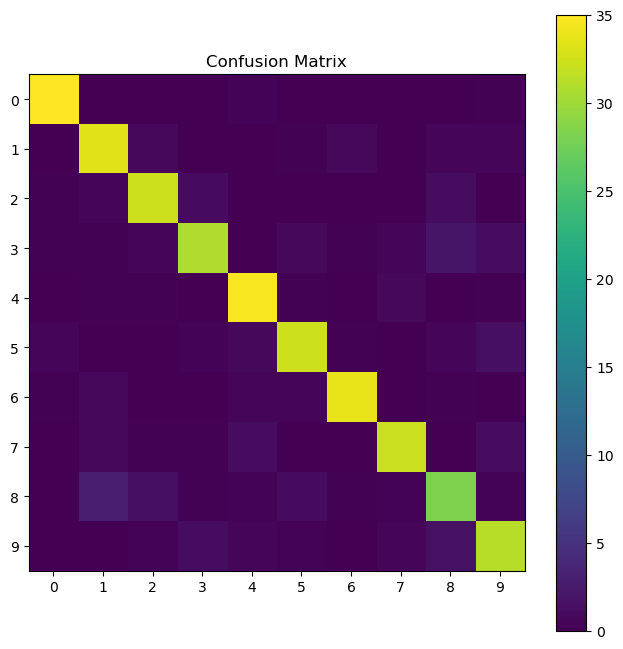

Confusion Matrix:
[[35.   0.   0.   0.   0.4  0.   0.   0.   0.   0.2]
 [ 0.  33.4  0.8  0.   0.   0.2  0.8  0.   0.6  0.6]
 [ 0.2  0.6 32.4  1.   0.   0.   0.   0.   1.2  0. ]
 [ 0.2  0.2  0.6 30.8  0.   0.8  0.2  0.6  2.   1.2]
 [ 0.   0.2  0.2  0.  34.6  0.2  0.   0.8  0.   0.2]
 [ 0.6  0.   0.   0.4  0.8 32.4  0.2  0.   0.6  1.4]
 [ 0.2  0.8  0.   0.   0.6  0.6 33.8  0.   0.2  0. ]
 [ 0.   0.8  0.2  0.2  1.2  0.   0.  32.2  0.   1.2]
 [ 0.   2.6  1.4  0.2  0.4  1.   0.2  0.4 28.2  0.4]
 [ 0.   0.   0.4  1.2  0.6  0.4  0.   0.6  1.6 31.2]]


In [13]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
# your code here
features = digits.data
labels = digits.target
def classification_forest_arbitrary(features,labels,n_folds=5,n_trees=10):
    accuracy_scores = [ ]
    confusion_matrices = []
    kfold = KFold(n_folds)
    for train_index, test_index in kfold.split(features):
        # Split the data into training and testing sets
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        forest = ClassificationForest(n_trees,np.unique(digits.target))
        forest.train(X_train, y_train)

        y_pred = [forest.predict(x) for x in X_test]

        accuracy = np.mean(y_pred == y_test)
        accuracy_scores.append(accuracy)
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
        #accuracy_scores+=accuracy

    average_accuracy = np.mean(accuracy_scores)
    average_cm = np.mean(confusion_matrices, axis=0)
    return average_accuracy,average_cm

accuracy_classficationforest,matrix=classification_forest_arbitrary(features,labels)
print('Classification Forest(arbitrary):',accuracy_classficationforest)

plt.figure(figsize=(8, 8))
plt.imshow(matrix)
plt.title('Confusion Matrix')
plt.colorbar()
marks = np.arange(len(np.unique(digits.target)))
plt.xticks(marks, np.unique(digits.target))
plt.yticks(marks, np.unique(digits.target))
plt.show()

# Comment on the results
print("Confusion Matrix:")
print(matrix)

# One-against-the-rest classification with RegressionForest

In [ ]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
# your code here
features = digits.data
labels = digits.target

def one_against_rest_regression_forest(features, labels, n_folds=5, n_trees=10):
    accuracy_scores = []
    confusion_matrices = []

    for target_class in np.unique(labels):
        binary_labels = np.where(labels == target_class, 1, -1)

        kfold = KFold(n_folds)
        for train_index, test_index in kfold.split(features):
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = binary_labels[train_index], binary_labels[test_index]

            forest = RegressionForest(n_trees)
            forest.train(X_train, y_train)

            y_pred = [forest.predict(x) for x in X_test]

            if all(score < 0 for score in y_pred):
                ypred_labels = "unknown"
            else:
                best_class = np.argmax(y_pred)
                ypred_labels = np.unique(labels)[best_class]

            accuracy = np.mean(ypred_labels == labels[test_index])
            accuracy_scores.append(accuracy)

            cm = confusion_matrix(labels[test_index], ypred_labels, labels=np.unique(labels))
            confusion_matrices.append(cm)

    average_accuracy = np.mean(accuracy_scores)
    average_cm = np.mean(confusion_matrices, axis=0)
    return average_accuracy, average_cm

accuracy, matrix = one_against_rest_regression_forest(features, labels)
print('Regression Forest :', accuracy)

plt.figure(figsize=(8, 8))
plt.imshow(matrix)
plt.title('Confusion Matrix')
plt.colorbar()
marks = np.arange(len(np.unique(labels)))
plt.xticks(marks, np.unique(labels))
plt.yticks(marks, np.unique(labels))
plt.show()

# Comment on the results
print("Confusion Matrix:")
print(matrix)

